# Autoregressive models - PixelCNN for multiple layers



In our previous notebook, we trained a generative model to create black and white drawings of numbers by learning the manifold distribution of the MNIST dataset. Now we are going to create a generative model with a similar architecture that is able to generate coloured images and is trained on the CIFAR10 dataset - a commonly used dataset for machine learning research which is composed of natural images of 10 different classes: airplanes, birds, cars, cats, deers, dogs, frogs, horses, ships and trucks. Besides having 3 channels of colour instead of one, these images are more complex and diverse than the hand-written numbers of the MNIST dataset, so it is more challenging for the model to learn the manifold that generates these images. Let's see how it fares.

This implementation uses Tensorflow 2.0. We start by installing and importing the code dependencies.

In [2]:
%tensorflow_version 2.x

In [3]:
import random as rn
import time

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras

To allow for reproducible results we fix a random seed.

In [4]:
# --------------------------------------------------------------------------------------------------------------
# Defining random seeds
random_seed = 42
tf.random.set_seed(random_seed)
np.random.seed(random_seed)
rn.seed(random_seed)

The original CIFAR10 dataset has 255 different intensity values for each sub-pixel. We use the `quantisize` function to define the number intensity values we are using and control for the complexity of the problem.

In [5]:
def quantisize(images, q_levels):
    """Digitize image into q levels"""
    return (np.digitize(images, np.arange(q_levels) / q_levels) - 1).astype('float32')

# Masked Convolution for sub-pixels
In the PixelCNN we use masks to control for the information the model has access when processing the data of a central pixel. The convolutional filter naturally considers all the pixels around it, so we use masks to block the information from the pixels that come after the central pixel in our pre-defined ordering.

When we are working with more than 1 channel (coloured images have 3), we need to make sure the sub-pixels don't have access to information yet to be processed. We need to adapt our masks to the information of future sub-pixels when processing each sub-pixel at a time. To do so, we ajust the `build` function in the `MaskedConv2D` class in order to block the central pixel's information for yet unseen sub-pixels just as is pictured in the red squares of the following image:


<center><img src="https://raw.githubusercontent.com/Mind-the-Pineapple/Autoregressive-models/master/2%20-%20Modelling%20data%20with%20multiple%20channels/figures/PixelcnnRGB.png" width="700"></center>

In [6]:
class MaskedConv2D(tf.keras.layers.Layer):
    """Convolutional layers with masks for autoregressive models

    Convolutional layers with simple implementation to have masks type A and B.
    """

    def __init__(self,
                 mask_type,
                 filters,
                 kernel_size,
                 strides=1,
                 padding='same',
                 kernel_initializer='glorot_uniform',
                 bias_initializer='zeros',
                 input_n_channels=3):
        super(MaskedConv2D, self).__init__()

        assert mask_type in {'A', 'B'}
        self.mask_type = mask_type

        self.filters = filters
        self.kernel_size = kernel_size
        self.strides = strides
        self.padding = padding.upper()
        self.kernel_initializer = keras.initializers.get(kernel_initializer)
        self.bias_initializer = keras.initializers.get(bias_initializer)
        self.input_n_channels = input_n_channels

    def build(self, input_shape):
        self.kernel = self.add_weight("kernel",
                                      shape=(self.kernel_size,
                                             self.kernel_size,
                                             int(input_shape[-1]),
                                             self.filters),
                                      initializer=self.kernel_initializer,
                                      trainable=True)

        self.bias = self.add_weight("bias",
                                    shape=(self.filters,),
                                    initializer=self.bias_initializer,
                                    trainable=True)
        center = self.kernel_size // 2
        mask = np.ones(self.kernel.shape, dtype=np.float32)
        mask[center, center + 1:, :, :] = 0
        mask[center + 1:, :, :, :] = 0

        for i in range(self.input_n_channels):
            for j in range(self.input_n_channels):
                if (self.mask_type == 'A' and i >= j) or (self.mask_type == 'B' and i > j):
                    mask[center, center, i::self.input_n_channels, j::self.input_n_channels] = 0

        self.mask = tf.constant(mask, dtype=tf.float32, name='mask')

    def call(self, input):
        masked_kernel = tf.math.multiply(self.mask, self.kernel)
        x = tf.nn.conv2d(input,
                         masked_kernel,
                         strides=[1, self.strides, self.strides, 1],
                         padding=self.padding)
        x = tf.nn.bias_add(x, self.bias)
        return x

The Residual block is an important building block of Oord's seminal paper that originated the PixelCNN.

In [7]:
class ResidualBlock(tf.keras.Model):
    """Residual blocks that compose pixelCNN

    Blocks of layers with 3 convolutional layers and one residual connection.
    Based on Figure 5 from [1] where h indicates number of filters.

    Refs:
    [1] - Oord, A. V. D., Kalchbrenner, N., & Kavukcuoglu, K. (2016). Pixel
     recurrent neural networks. arXiv preprint arXiv:1601.06759.
    """

    def __init__(self, h):
        super(ResidualBlock, self).__init__(name='')

        self.conv2a = MaskedConv2D(mask_type='B', filters=h//2, kernel_size=1, strides=1)
        self.conv2b = MaskedConv2D(mask_type='B', filters=h//2, kernel_size=7, strides=1)
        self.conv2c = MaskedConv2D(mask_type='B', filters=h, kernel_size=1, strides=1)

    def call(self, input_tensor):
        x = tf.nn.relu(input_tensor)
        x = self.conv2a(x)

        x = tf.nn.relu(x)
        x = self.conv2b(x)

        x = tf.nn.relu(x)
        x = self.conv2c(x)

        x += input_tensor
        return x

# Overfitting to 2 examples

Generating natural-looking coloured images is challenging. To make sure the implementation is sound and learning is happening, we start by learning an easier problem. We do so, by overfitting the generative model to just 2 examples - a frog and a truck. In this case, if everything is working correctly, the model will memorize the two examples and replicate them with near perfect accuracy, instead of generalizing for different unseen examples, which is what happens when there is no overfitting.

In [10]:
# --------------------------------------------------------------------------------------------------------------
# Loading data
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

height = 32
width = 32
n_channel = 3

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

x_train = x_train.reshape(x_train.shape[0], height, width, n_channel)
x_test = x_test.reshape(x_test.shape[0], height, width, n_channel)

x_train_overfit = np.tile(x_train[:2], 25000)
x_train_overfit = x_train_overfit.reshape(2,32,32,25000,3)
x_train_overfit = np.transpose(x_train_overfit, (0,3,1,2,4)).reshape(50000,32,32,3)
x_test_overfit = x_train_overfit

170500096/170498071 [==============================] - 3s 0us/step


In [62]:
# --------------------------------------------------------------------------------------------------------------
# Quantisize the input data in q levels
q_levels = 128
x_train_quantised_of = quantisize(x_train_overfit, q_levels)
x_test_quantised_of = quantisize(x_test_overfit, q_levels)

Training examples


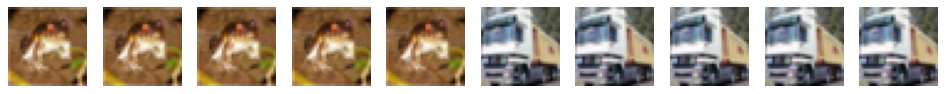

Testing examples


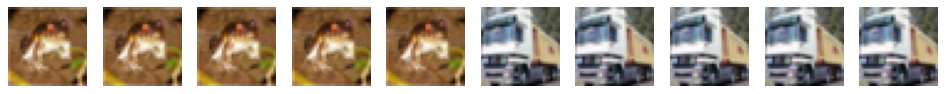

In [9]:
# Check the first samples
print('Training examples')
fig,ax = plt.subplots(1, 10, figsize=(15, 10), dpi=80)
for i in range(10):
        ax[i].imshow(x_train_quantised_of[i*5000]/(q_levels-1))
[x.axis('off') for x in ax]
plt.show()
print('Testing examples')
fig,ax = plt.subplots(1, 10, figsize=(15, 10), dpi=80)
for i in range(10):
        ax[i].imshow(x_test_quantised_of[i*5000]/(q_levels-1))
[x.axis('off') for x in ax]
plt.show()

In [ ]:
# --------------------------------------------------------------------------------------------------------------
# Creating input stream using tf.data API
batch_size = 128
train_buf = 60000

train_dataset = tf.data.Dataset.from_tensor_slices((x_train_quantised_of / (q_levels - 1),
                                                    x_train_quantised_of.astype('int32')))
train_dataset = train_dataset.shuffle(buffer_size=train_buf)
train_dataset = train_dataset.batch(batch_size)

test_dataset = tf.data.Dataset.from_tensor_slices((x_test_quantised_of / (q_levels - 1),
                                                   x_test_quantised_of.astype('int32')))
test_dataset = test_dataset.batch(batch_size)

In [12]:
# --------------------------------------------------------------------------------------------------------------
# Create PixelCNN model
n_filters = 120 
inputs = keras.layers.Input(shape=(height, width, n_channel))
x = MaskedConv2D(mask_type='A', filters=n_filters, kernel_size=7)(inputs)

for i in range(15):
    x = keras.layers.Activation(activation='relu')(x)
    x = ResidualBlock(h=n_filters)(x)

x = keras.layers.Activation(activation='relu')(x)
x = MaskedConv2D(mask_type='B', filters=n_filters, kernel_size=1)(x) 
x = keras.layers.Activation(activation='relu')(x)
x = MaskedConv2D(mask_type='B', filters=n_channel * q_levels, kernel_size=1)(x)  # shape [N,H,W,DC]

pixelcnn = tf.keras.Model(inputs=inputs, outputs=x)

In [13]:
# --------------------------------------------------------------------------------------------------------------
# Prepare optimizer and loss function
lr_decay = 0.9999
learning_rate = 5e-3 #5
optimizer = tf.keras.optimizers.Adam(lr=learning_rate)

compute_loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True)

In [14]:
# --------------------------------------------------------------------------------------------------------------
@tf.function
def train_step(batch_x, batch_y):
    with tf.GradientTape() as ae_tape:
        logits = pixelcnn(batch_x, training=True)

        logits = tf.reshape(logits, [-1, height, width, q_levels, n_channel])
        logits = tf.transpose(logits, perm=[0, 1, 2, 4, 3])

        loss = compute_loss(tf.one_hot(batch_y, q_levels), logits)

    gradients = ae_tape.gradient(loss, pixelcnn.trainable_variables)
    gradients, _ = tf.clip_by_global_norm(gradients, 1.0)
    optimizer.apply_gradients(zip(gradients, pixelcnn.trainable_variables))

    return loss

We train the model for 10 epochs and we can see in no time the loss function dropping to almost 0. When the model generates new examples, it will show almost identical images to the two it was presented during training.

In [14]:
# --------------------------------------------------------------------------------------------------------------
# Training loop

n_epochs = 10
val_error = []
n_iter = int(np.ceil(x_train_quantised_of.shape[0] / batch_size))
for epoch in range(n_epochs):

    start_epoch = time.time()
    for i_iter, (batch_x, batch_y) in enumerate(train_dataset):

        start = time.time()
        optimizer.lr = optimizer.lr * lr_decay
        loss = train_step(batch_x, batch_y)
        val_error.append(loss)
        iter_time = time.time() - start
        if i_iter % 100 == 0:
            print('EPOCH {:3d}: ITER {:4d}/{:4d} TIME: {:.2f} LOSS: {:.4f}'.format(epoch,
                                                                                   i_iter, n_iter,
                                                                                   iter_time,
                                                                                   loss))
    epoch_time = time.time() - start_epoch
    print('EPOCH {:3d}: TIME: {:.2f} ETA: {:.2f}'.format(epoch,
                                                         epoch_time,
                                                         epoch_time * (n_epochs - epoch)))

EPOCH   0: ITER    0/ 391 TIME: 11.56 LOSS: 4.8524
EPOCH   0: ITER  100/ 391 TIME: 1.00 LOSS: 3.4277
EPOCH   0: ITER  200/ 391 TIME: 1.01 LOSS: 2.4261
EPOCH   0: ITER  300/ 391 TIME: 1.01 LOSS: 1.4569
EPOCH   0: TIME: 409.76 ETA: 4097.59
EPOCH   1: ITER    0/ 391 TIME: 0.22 LOSS: 1.0011
EPOCH   1: ITER  100/ 391 TIME: 1.01 LOSS: 0.5937
EPOCH   1: ITER  200/ 391 TIME: 1.01 LOSS: 0.3431
EPOCH   1: ITER  300/ 391 TIME: 1.01 LOSS: 0.3064
EPOCH   1: TIME: 396.34 ETA: 3567.05
EPOCH   2: ITER    0/ 391 TIME: 0.22 LOSS: 0.2177
EPOCH   2: ITER  100/ 391 TIME: 1.01 LOSS: 0.2410
EPOCH   2: ITER  200/ 391 TIME: 1.01 LOSS: 0.1268
EPOCH   2: ITER  300/ 391 TIME: 1.00 LOSS: 0.1524
EPOCH   2: TIME: 395.96 ETA: 3167.71
EPOCH   3: ITER    0/ 391 TIME: 0.22 LOSS: 0.0689
EPOCH   3: ITER  100/ 391 TIME: 1.01 LOSS: 0.0449
EPOCH   3: ITER  200/ 391 TIME: 1.00 LOSS: 0.0476
EPOCH   3: ITER  300/ 391 TIME: 1.00 LOSS: 0.0387
EPOCH   3: TIME: 395.65 ETA: 2769.57
EPOCH   4: ITER    0/ 391 TIME: 0.22 LOSS: 0.0423
E

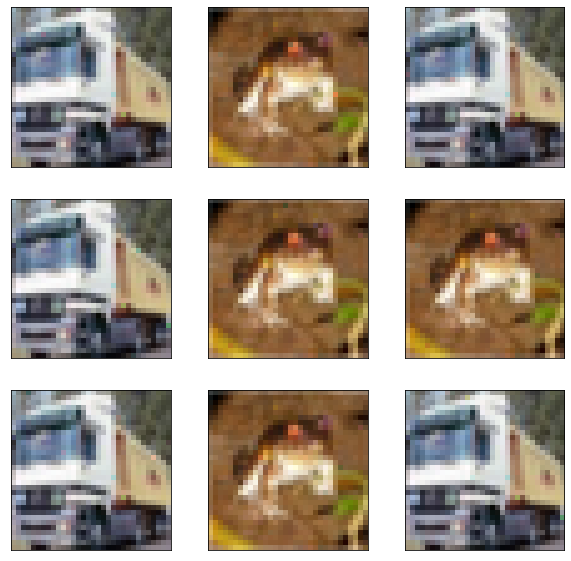

In [15]:
# --------------------------------------------------------------------------------------------------------------
# Generating new images
samples = np.zeros((9, height, width, n_channel), dtype='float32')
for i in range(height):
    for j in range(width):
        for k in range(n_channel):
            logits = pixelcnn(samples)
            logits = tf.reshape(logits, [-1, height, width, q_levels, n_channel])
            logits = tf.transpose(logits, perm=[0, 1, 2, 4, 3])
            next_sample = tf.random.categorical(logits[:, i, j, k, :], 1)
            samples[:, i, j, k] = (next_sample.numpy() / (q_levels - 1))[:, 0]
            

fig = plt.figure(figsize=(10, 10))
for i in range(9):
    ax = fig.add_subplot(3, 3, i+1)
    ax.imshow(samples[i, :, :, :])
    plt.xticks(np.array([]))
    plt.yticks(np.array([]))
plt.show()

Now, if our test set contains images that were not the two that the model overfit to, the loss will be large as the model is not able to recreate the unseen image. It is only able to recreate the two memorized images.

In [17]:
# --------------------------------------------------------------------------------------------------------------
# Test
x_train_quantised = quantisize(x_train, q_levels)
x_test_quantised = quantisize(x_test, q_levels)

test_dataset = tf.data.Dataset.from_tensor_slices((x_test_quantised / (q_levels - 1),
                                                   x_test_quantised.astype('int32')))
test_dataset = test_dataset.batch(batch_size)

test_loss = []
for batch_x, batch_y in test_dataset:
    logits = pixelcnn(batch_x, training=False)
    logits = tf.reshape(logits, [-1, height, width, q_levels, n_channel])
    logits = tf.transpose(logits, perm=[0, 1, 2, 4, 3])

    # Calculate cross-entropy (= negative log-likelihood)
    loss = compute_loss(tf.one_hot(batch_y, q_levels), logits)

    test_loss.append(loss)
print('nll : {:} nats'.format(np.array(test_loss).mean()))
print('bits/dim : {:}'.format(np.array(test_loss).mean() / (height * width)))

nll : 126.13430786132812 nats
bits/dim : 0.12317803502082825


A similar result is obtained if we try to use the model to predict half of an occluded image. All the model is able to do is present the two examples it has seen. Let's then try to make the model learn the manifold distribution of the whole CIFAR10 dataset and create unseen examples of natural images.

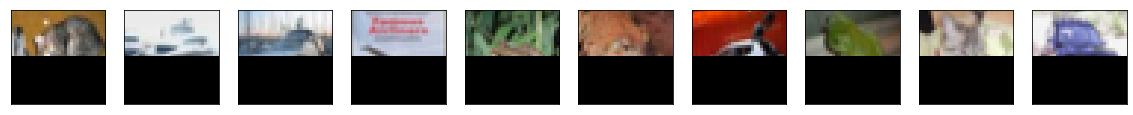

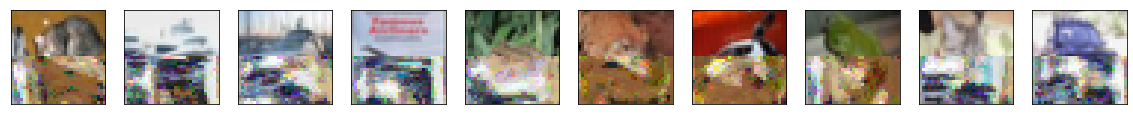

In [23]:
  # Filling occluded images
  occlude_start_row = 16
  num_generated_images = 10
  samples = np.copy(x_test_quantised[0:num_generated_images, :, :, :])
  samples = samples / (q_levels - 1)
  samples[:, occlude_start_row:, :, :] = 0

  fig = plt.figure(figsize=(20, 20))

  for i in range(10):
      ax = fig.add_subplot(1, 10, i + 1)
      ax.matshow(samples[i, :, :, :], cmap=matplotlib.cm.binary)
      plt.xticks(np.array([]))
      plt.yticks(np.array([]))

  for i in range(occlude_start_row, height):
      for j in range(width):
        for k in range(n_channel):
          logits = pixelcnn(samples)
          logits = tf.reshape(logits, [-1, height, width, q_levels, n_channel])
          logits = tf.transpose(logits, perm=[0, 1, 2, 4, 3])
          next_sample = tf.random.categorical(logits[:, i, j, k, :], 1)
          samples[:, i, j, k] = (next_sample.numpy() / (q_levels - 1))[:, 0]

  fig = plt.figure(figsize=(20, 20))

  for i in range(10):
      ax = fig.add_subplot(1, 10, i + 1)
      ax.matshow(samples[i, :, :, :], cmap=matplotlib.cm.binary)
      plt.xticks(np.array([]))
      plt.yticks(np.array([]))
  plt.show()


# Generalizing CIFAR10 images

Now we will be using 100000 different images of the 10 classes presented in CIFAR10. For now, this is a challenge for our current implementation of the PixelCNN. To facilitate the model's training we are reducing the number of intensity values of each sub-pixel - from 256 to 8. This means the images will have less resolution.

Training examples


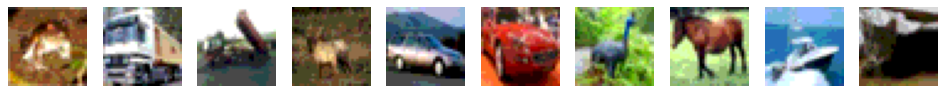

Testing examples


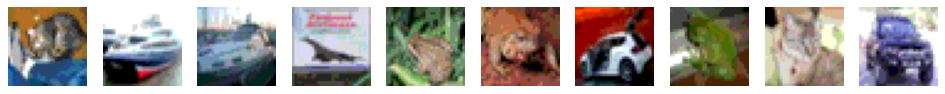

In [11]:
# --------------------------------------------------------------------------------------------------------------
# Quantisize the input data in q levels
q_levels = 8
x_train_quantised = quantisize(x_train, q_levels)
x_test_quantised = quantisize(x_test, q_levels)

# Check the first samples
print('Training examples')
fig,ax = plt.subplots(1, 10, figsize=(15, 10), dpi=80)
for i in range(10):
        ax[i].imshow(x_train_quantised[i]/(q_levels-1))
[x.axis('off') for x in ax]
plt.show()
print('Testing examples')
fig,ax = plt.subplots(1, 10, figsize=(15, 10), dpi=80)
for i in range(10):
        ax[i].imshow(x_test_quantised[i]/(q_levels-1))
[x.axis('off') for x in ax]
plt.show()

train_dataset = tf.data.Dataset.from_tensor_slices((x_train_quantised / (q_levels - 1),
                                                    x_train_quantised.astype('int32')))
train_dataset = train_dataset.shuffle(buffer_size=train_buf)
train_dataset = train_dataset.batch(batch_size)

test_dataset = tf.data.Dataset.from_tensor_slices((x_test_quantised / (q_levels - 1),
                                                   x_test_quantised.astype('int32')))
test_dataset = test_dataset.batch(batch_size)

We train the model for 20 epochs.

In [15]:
# --------------------------------------------------------------------------------------------------------------
# Training loop
pixelcnn = tf.keras.Model(inputs=inputs, outputs=x)

n_epochs = 20
val_error = []
n_iter = int(np.ceil(x_train_quantised.shape[0] / batch_size))
for epoch in range(n_epochs):

    start_epoch = time.time()
    for i_iter, (batch_x, batch_y) in enumerate(train_dataset):

        start = time.time()
        optimizer.lr = optimizer.lr * lr_decay
        loss = train_step(batch_x, batch_y)
        val_error.append(loss)
        iter_time = time.time() - start
        if i_iter % 100 == 0:
            print('EPOCH {:3d}: ITER {:4d}/{:4d} TIME: {:.2f} LOSS: {:.4f}'.format(epoch,
                                                                                   i_iter, n_iter,
                                                                                   iter_time,
                                                                                   loss))
    epoch_time = time.time() - start_epoch
    print('EPOCH {:3d}: TIME: {:.2f} ETA: {:.2f}'.format(epoch,
                                                         epoch_time,
                                                         epoch_time * (n_epochs - epoch)))

EPOCH   0: ITER    0/ 391 TIME: 11.04 LOSS: 2.0768
EPOCH   0: ITER  100/ 391 TIME: 0.92 LOSS: 1.1606
EPOCH   0: ITER  200/ 391 TIME: 0.93 LOSS: 0.9095
EPOCH   0: ITER  300/ 391 TIME: 0.92 LOSS: 0.7589
EPOCH   0: TIME: 375.12 ETA: 7502.38
EPOCH   1: ITER    0/ 391 TIME: 0.20 LOSS: 0.6693
EPOCH   1: ITER  100/ 391 TIME: 0.92 LOSS: 0.6433
EPOCH   1: ITER  200/ 391 TIME: 0.92 LOSS: 0.5806
EPOCH   1: ITER  300/ 391 TIME: 0.93 LOSS: 0.5253
EPOCH   1: TIME: 364.26 ETA: 6920.88
EPOCH   2: ITER    0/ 391 TIME: 0.21 LOSS: 0.5504
EPOCH   2: ITER  100/ 391 TIME: 0.92 LOSS: 0.5570
EPOCH   2: ITER  200/ 391 TIME: 0.93 LOSS: 0.5388
EPOCH   2: ITER  300/ 391 TIME: 0.93 LOSS: 0.5375
EPOCH   2: TIME: 365.10 ETA: 6571.84
EPOCH   3: ITER    0/ 391 TIME: 0.21 LOSS: 0.5209
EPOCH   3: ITER  100/ 391 TIME: 0.93 LOSS: 0.5560
EPOCH   3: ITER  200/ 391 TIME: 0.93 LOSS: 0.5015
EPOCH   3: ITER  300/ 391 TIME: 0.93 LOSS: 0.5159
EPOCH   3: TIME: 365.68 ETA: 6216.59
EPOCH   4: ITER    0/ 391 TIME: 0.21 LOSS: 0.5077
E

We can now see that the model has a good result also on the test set when presented with unseen images. This is a good pointer that the model has been successful in learning the dataset images manifold.

In [16]:
# --------------------------------------------------------------------------------------------------------------
# Test

test_loss = []
for batch_x, batch_y in test_dataset:
    logits = pixelcnn(batch_x, training=False)
    logits = tf.reshape(logits, [-1, height, width, q_levels, n_channel])
    logits = tf.transpose(logits, perm=[0, 1, 2, 4, 3])

    # Calculate cross-entropy (= negative log-likelihood)
    loss = compute_loss(tf.one_hot(batch_y, q_levels), logits)

    test_loss.append(loss)
print('nll : {:} nats'.format(np.array(test_loss).mean()))
print('bits/dim : {:}'.format(np.array(test_loss).mean() / (height * width)))


nll : 0.4649888575077057 nats
bits/dim : 0.00045409068115986884


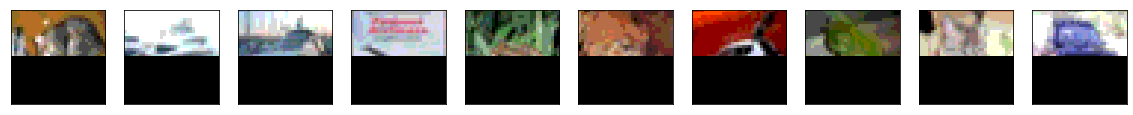

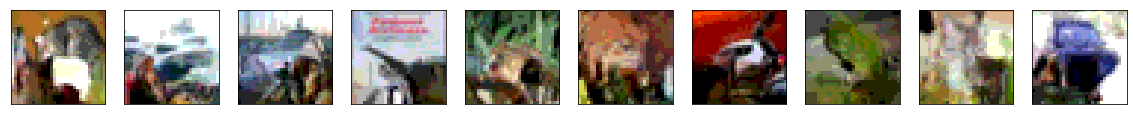

In [17]:
# Filling occluded images
occlude_start_row = 16
num_generated_images = 10
samples = np.copy(x_test_quantised[0:num_generated_images, :, :, :])
samples = samples / (q_levels - 1)
samples[:, occlude_start_row:, :, :] = 0

fig = plt.figure(figsize=(20, 20))

for i in range(10):
    ax = fig.add_subplot(1, 10, i + 1)
    ax.matshow(samples[i, :, :, :], cmap=matplotlib.cm.binary)
    plt.xticks(np.array([]))
    plt.yticks(np.array([]))

for i in range(occlude_start_row, height):
    for j in range(width):
      for k in range(n_channel):
        logits = pixelcnn(samples)
        logits = tf.reshape(logits, [-1, height, width, q_levels, n_channel])
        logits = tf.transpose(logits, perm=[0, 1, 2, 4, 3])
        next_sample = tf.random.categorical(logits[:, i, j, k, :], 1)
        samples[:, i, j, k] = (next_sample.numpy() / (q_levels - 1))[:, 0]

fig = plt.figure(figsize=(20, 20))

for i in range(10):
    ax = fig.add_subplot(1, 10, i + 1)
    ax.matshow(samples[i, :, :, :], cmap=matplotlib.cm.binary)
    plt.xticks(np.array([]))
    plt.yticks(np.array([]))
plt.show()

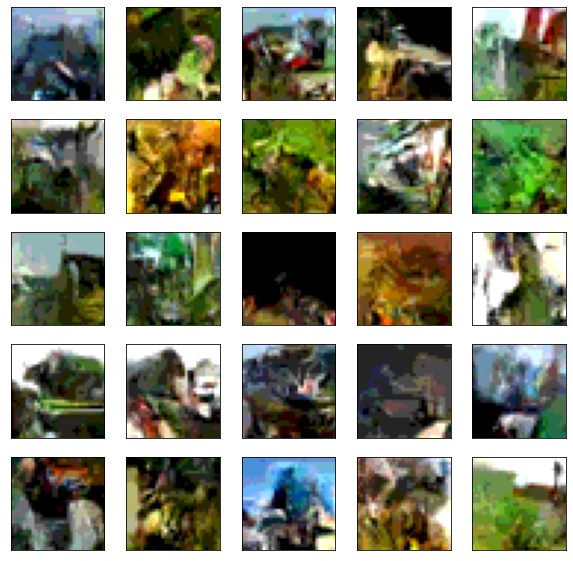

In [19]:
# --------------------------------------------------------------------------------------------------------------
# Generating new images
samples = np.zeros((25, height, width, n_channel), dtype='float32')
for i in range(height):
    for j in range(width):
        for k in range(n_channel):
            logits = pixelcnn(samples)
            logits = tf.reshape(logits, [-1, height, width, q_levels, n_channel])
            logits = tf.transpose(logits, perm=[0, 1, 2, 4, 3])
            next_sample = tf.random.categorical(logits[:, i, j, k, :], 1)
            samples[:, i, j, k] = (next_sample.numpy() / (q_levels - 1))[:, 0]
            

fig = plt.figure(figsize=(10, 10))
for i in range(25):
    ax = fig.add_subplot(5, 5, i+1)
    ax.imshow(samples[i, :, :, :])
    plt.xticks(np.array([]))
    plt.yticks(np.array([]))
plt.show()

We can see that the images present natural colours and patterns, sometimes identifying what might be a horse or a truck. Since Oord's paper in 2016, there has been a lot of progress in the implementation of the PixelCNN, with each iteration generating more and more realistic looking images. In our next blogposts and notebooks we are going to address these new tricks and changes in order to create better images. So stay tuned!